In [381]:
%matplotlib notebook
import math
import numpy as np
from skimage.measure import label, regionprops
from skimage import data, color
import matplotlib.pyplot as plt
from scipy.ndimage.filters import sobel
from skimage.morphology import watershed
from skimage import filters
from scipy import ndimage as ndi
from scipy.optimize import curve_fit
import skimage
import pandas as pd
import glob as glob
import pims
import exifread
import matplotlib
matplotlib.style.use('ggplot')
import os
import re
import itertools

In [133]:
#First, read in the data created by imagej.
%ls

bg/  film1/  film2/  film3/  Untitled1.ipynb  Untitled2.ipynb  Untitled.ipynb


In [134]:
names = [x for x in os.walk('.')]

In [135]:
names[2][2][names[2][2]=='*.txt']

'b-exp14-12-9-8.txt'

In [136]:
txttest = re.compile('.*\.txt')

In [137]:
[m for name in names[2][2] for m in [txttest.search(name)]]

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [138]:
[names[2][0]+"/"+matchedfilename for matchedfilename in [
        txttest.search(name).group(0) for name in names[2][2] if txttest.search(name)]]

['./bg/b-exp14-12-9-8.txt', './bg/g-exp8-7-4-2.txt', './bg/r-exp-12-10-7.txt']

In [139]:
rawfilenames=pd.Series([directory[0]+"/"+matchedfilename for directory in names for matchedfilename in [
        txttest.search(name).group(0) for name in directory[2] if txttest.search(name)]
    ] )

In [140]:
#Now, started building data structures of files

rawfilenames

0                              ./bg/b-exp14-12-9-8.txt
1                                ./bg/g-exp8-7-4-2.txt
2                               ./bg/r-exp-12-10-7.txt
3                     ./film1/thinlayer/g-exp6-7-8.txt
4     ./film3/thin/T120/good/B-exp-3d8-4d8-7d8-8d8.txt
5         ./film3/thin/T120/good/G-exp-d3-d5-1-1d8.txt
6    ./film3/thin/T120/good/R-exp1d8-2d8-3d8-4d8-8d...
dtype: object

In [141]:
exptest = re.compile('.*exp(d?[0-9]*d?-?)*')

In [142]:
[exptest.search(name).group() for name in rawfilenames if exptest.search(name)]

['./bg/b-exp14-12-9-8',
 './bg/g-exp8-7-4-2',
 './bg/r-exp-12-10-7',
 './film1/thinlayer/g-exp6-7-8',
 './film3/thin/T120/good/B-exp-3d8-4d8-7d8-8d8',
 './film3/thin/T120/good/G-exp-d3-d5-1-1d8',
 './film3/thin/T120/good/R-exp1d8-2d8-3d8-4d8-8d8']

In [222]:
#Or, a better way to do it
#complicated regrex. ?: marks first group as non-saving, then just match on larger group
explist = rawfilenames.str.extract('.*exp-?((?:d?[0-9]*d?-*)*)').str.replace('d','.').str.split('-')
dtest = re.compile('.*exp-?((?:d?[0-9]*d?-*)*)')
ctest = re.compile('.*/([rbgRBG])-')
thintest = re.compile('./((?:film[123])|(?:bg))')

In [227]:
meangreyvalue =pd.DataFrame([(name,thintest.search(name).group(1), ctest.search(name).group(1).lower(), [float(i) for i in dtest.search(name).group(1).replace('d','.').split('-')],
                              np.loadtxt(name, unpack=True)[1]) for name in rawfilenames])
meangreyvalue.columns=(['filename','film num','colour','exposure','mean grey value'])
meangreyvalue['fit']=[np.polyfit(row['exposure'],np.array(row['mean grey value']),1) for indx, row in meangreyvalue.iterrows()]

In [228]:
meangreyvalue

,filename,film num,colour,exposure,mean grey value,fit
0,./bg/b-exp14-12-9-8.txt,bg,b,"[14.0, 12.0, 9.0, 8.0]","[1574.0692, 1375.2998, 1077.1549, 977.7592]","[99.3842098901, 182.690518681]"
1,./bg/g-exp8-7-4-2.txt,bg,g,"[8.0, 7.0, 4.0, 2.0]","[2605.5669, 2356.8511, 1452.4237, 826.0174]","[298.448889011, 243.358107692]"
2,./bg/r-exp-12-10-7.txt,bg,r,"[12.0, 10.0, 7.0]","[1720.5914, 1371.4452, 1018.9519]","[138.525521053, 31.2494631579]"
3,./film1/thinlayer/g-exp6-7-8.txt,film1,g,"[6.0, 7.0, 8.0]","[1769.059, 2060.2859, 2318.3167]","[274.62885, 126.818583333]"
4,./film3/thin/T120/good/B-exp-3d8-4d8-7d8-8d8.txt,film3,b,"[3.8, 4.8, 7.8, 8.8]","[1063.7899, 1296.5673, 1983.1188, 2210.0703]","[229.148720588, 194.749635294]"
5,./film3/thin/T120/good/G-exp-d3-d5-1-1d8.txt,film3,g,"[0.3, 0.5, 1.0, 1.8]","[653.6911, 956.7947, 1696.9297, 2771.7607]","[1409.959, 250.83095]"
6,./film3/thin/T120/good/R-exp1d8-2d8-3d8-4d8-8d...,film3,r,"[1.8, 2.8, 3.8, 4.8, 8.8]","[659.2731, 925.4943, 1183.3534, 1442.6135, 244...","[254.631700685, 210.999796986]"


<IPython.core.display.Javascript object>


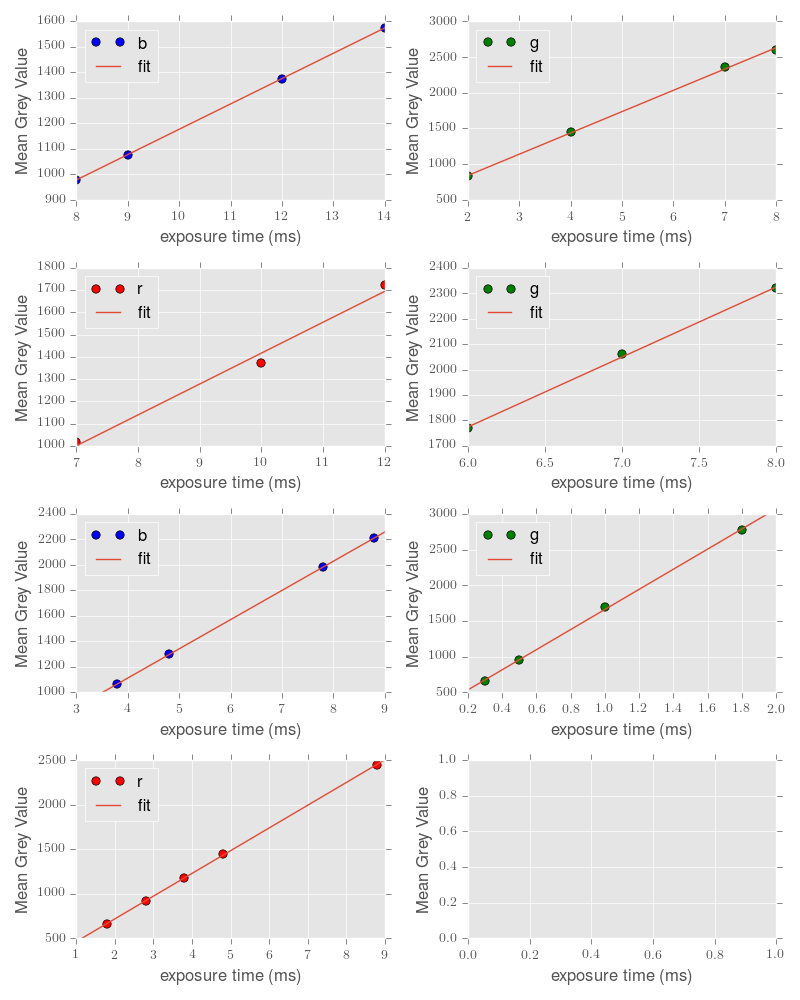

In [234]:
nrows = int(math.ceil(meangreyvalue.shape[0]/2.))
fig, axs = plt.subplots(nrows,2, figsize=(8,10))
xran = np.arange(0,15,.1)
[(axs.flat[i].plot(mgv['exposure'],mgv['mean grey value'],mgv['colour'],marker='o',ls='',label=mgv['colour']),
axs.flat[i].plot(xran,np.polyval(mgv['fit'],xran,),label='fit',scalex=False,scaley=False))
 for i,mgv in meangreyvalue.iterrows()]

[(ax.set_ylabel('Mean Grey Value'), ax.set_xlabel('exposure time (ms)'),ax.legend(loc='best')) for ax in axs.flat]


fig.tight_layout()

<IPython.core.display.Javascript object>


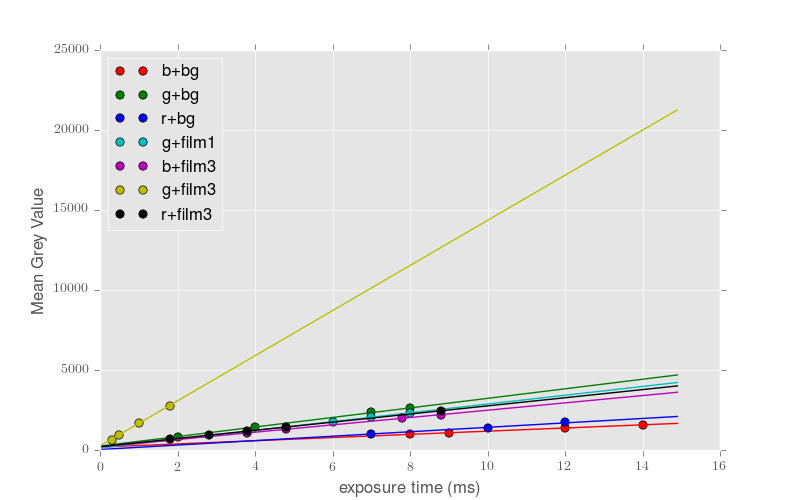

In [250]:
fig2, ax2 = plt.subplots( figsize=(8,5))
color = itertools.cycle(['r','r','g','g','b','b','c','c','m','m','y','y','k','k'])
[(ax2.plot(mgv['exposure'],mgv['mean grey value'],color=next(color),marker='o',ls='',label=mgv['colour']+'+'+mgv['film num']),
ax2.plot(xran,np.polyval(mgv['fit'],xran,),color=next(color)))
 for i,mgv in meangreyvalue.iterrows()]

ax2.set_ylabel('Mean Grey Value') 
ax2.set_xlabel('exposure time (ms)')
ax2.legend(loc='best')


fig.tight_layout()

In [366]:
#Create Plot of Reflectivities

meangreyvalue['ref']= [row['fit'][0]/meangreyvalue[
        (meangreyvalue['film num']=='bg') & (meangreyvalue['colour']==row['colour'])
    ]['fit'].values[0][0]*0.04 for ind, row in meangreyvalue.iterrows()]

In [367]:
meangreyvalue

,filename,film num,colour,exposure,mean grey value,fit,ref
0,./bg/b-exp14-12-9-8.txt,bg,b,"[14.0, 12.0, 9.0, 8.0]","[1574.0692, 1375.2998, 1077.1549, 977.7592]","[99.3842098901, 182.690518681]",0.040000
1,./bg/g-exp8-7-4-2.txt,bg,g,"[8.0, 7.0, 4.0, 2.0]","[2605.5669, 2356.8511, 1452.4237, 826.0174]","[298.448889011, 243.358107692]",0.040000
2,./bg/r-exp-12-10-7.txt,bg,r,"[12.0, 10.0, 7.0]","[1720.5914, 1371.4452, 1018.9519]","[138.525521053, 31.2494631579]",0.040000
3,./film1/thinlayer/g-exp6-7-8.txt,film1,g,"[6.0, 7.0, 8.0]","[1769.059, 2060.2859, 2318.3167]","[274.62885, 126.818583333]",0.036807
4,./film3/thin/T120/good/B-exp-3d8-4d8-7d8-8d8.txt,film3,b,"[3.8, 4.8, 7.8, 8.8]","[1063.7899, 1296.5673, 1983.1188, 2210.0703]","[229.148720588, 194.749635294]",0.092227
5,./film3/thin/T120/good/G-exp-d3-d5-1-1d8.txt,film3,g,"[0.3, 0.5, 1.0, 1.8]","[653.6911, 956.7947, 1696.9297, 2771.7607]","[1409.959, 250.83095]",0.188972
6,./film3/thin/T120/good/R-exp1d8-2d8-3d8-4d8-8d...,film3,r,"[1.8, 2.8, 3.8, 4.8, 8.8]","[659.2731, 925.4943, 1183.3534, 1442.6135, 244...","[254.631700685, 210.999796986]",0.073526


In [361]:
x =[meangreyvalue[(meangreyvalue['colour']==row['colour'])& (meangreyvalue['film num'] == 'bg')]['fit'].values[0][0]
  for ind, row in meangreyvalue.iterrows()]

In [272]:
meangreyvalue[
        (meangreyvalue['film num']=='bg') & (meangreyvalue['colour']=='b')
    ][1 ]

0    [99.3842098901, 182.690518681]
Name: fit, dtype: object

In [370]:
#Load and check out histogram method for getting average values
#Function to read in files, return dataframe with main qualities
filebase='./bg/*.tif'
filelist = pd.Series(glob.glob(filebase))
frames = pd.Series(plt.imread(f) for f in filelist)
expTime = filelist.str.extract('.[Ee]xp(\d*d?\d*)').str.replace('d','.').astype(float)
mainFrame = pd.DataFrame({'name': filelist, 'exp (ms)':expTime})

<IPython.core.display.Javascript object>


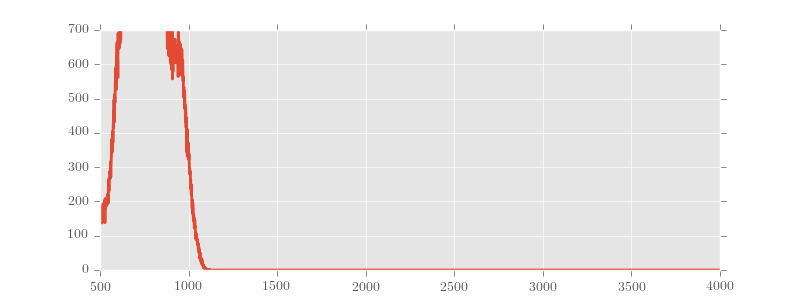

(0, 700)

In [429]:
#Function to operate on test image

#First plot histogram
testimage = np.copy(frames[4])
hst = np.histogram(testimage, bins = np.arange(0,4096))
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(hst[1][:-1],hst[0],lw=2)
plt.xlim([500,4000])
plt.ylim([0,700])

In [430]:
def gauss(x,*p):
    a, mu, sig = p
    return a*np.exp(-(x-mu)**2./(2.*sig**2.))

In [440]:
p0 = [700.,900,100]
coeff, var_matrix = curve_fit(gauss,hst[1][:-1][hst[1][:-1]>200],hst[0][hst[1][:-1]>200],p0=p0)

<IPython.core.display.Javascript object>


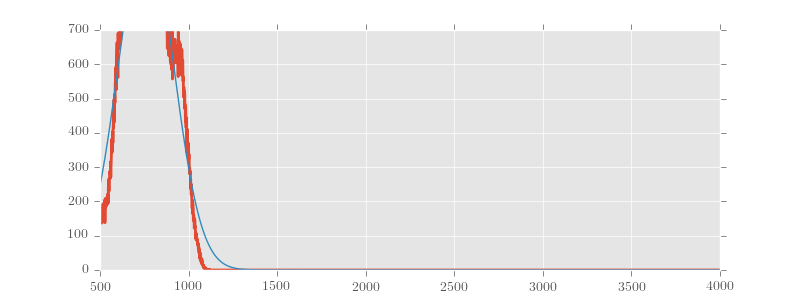

(0, 700)

In [441]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(hst[1][:-1],hst[0],lw=2)
plt.plot(hst[1][:-1],gauss(hst[1][:-1],*coeff))


plt.xlim([500,4000])
plt.ylim([0,700])

In [442]:
coeff

array([ 990.86045356,  759.32722805,  155.4646941 ])

In [444]:
mainFrame.ix[4]

exp (ms)                                2
name        ./bg/exp2-shutteropenG-bg.tif
Name: 4, dtype: object